# Introduction

I wanted a way to try and pick a single cell pipeline. My best guess was to try and find the one that worked most like the STAR/rsem pipeline we use for the bulk RNA-seq. If we sum all of the single cells together, does it act like having run the bulk single cell pipeline on the concatination of all the single cell reads?

Throughout this notebook "sc" stands for a sum of all the single cell libraries and "pop" refers to pooling the single cell fastqs into a population and feeding the combined fastq through the a bulk RNA-seq pipeline.

Given a single cell "genes" by "cell" matrix like the following, I calculate the sum along the gene axis.

$\sum_{i=0}^{c} \begin{pmatrix}
x_{00} & x_{01} & \ldots & x_{0c} \\
x_{10} & x_{11} & \ldots & x_{1c} \\
\vdots & \vdots & \ddots & \vdots \\
x_{g0} & x_{g1} & \ldots & x_{gc} \\
\end{pmatrix} = \begin{pmatrix}
x_{00} + x_{01} + \ldots + x_{oc} \\
x_{10} + x_{11} + \ldots + x_{1c} \\
\vdots \\
x_{g0} + x_{g1} + \ldots + x_{gc} \\
\end{pmatrix} = \begin{pmatrix}
x_{o} \\
x_{1} \\
\vdots \\
x_{g} \\
\end{pmatrix}$

I then compare that single column sum to the equivalent population column extracted from the bulk run.

Kallisto and Salmon's bulk pipelines generate transcript level quantifications, to compute the equivalent gene quantifications, I added a the gene id each transcript belonged to, then summed entries with the same gene ID together.

Everything was aligned with indices built with from the ENCODE mm10 M21 male files, kallisto and salmon decoy used the rsem.transcripts.fa file from ENCFF363TFV for their transcriptome model and salmon no decoy used rsem.idx.fa and should be re-run. the salmon decoy index might need to be rebuilt as well as it was provided the spikes twice.

<table>
    <tr><td>Cellranger</td><td>3.1.0</td></tr>
    <tr><td>STAR</td><td>2.7.5a</td></tr>
    <tr><td>Kallisto</td><td>0.46.2</td></tr>
    <tr><td>Salmon</td><td>1.2.1</td></tr>
</table>

# Setup

See <a href="build-10x-e10.5-population-looms.html">build-10x-e10.5-population-looms.html</a> to see how the quantification matrixes were built. See <a href="compare-10x-sum-vs-population.html">compare-10x-sum-vs-population.html</a> to see the full notebook.

In [1]:
import pandas
import scanpy
from pathlib import Path
import sys
import itertools
from matplotlib import pyplot
import numpy
from urllib import parse
import loompy
import scanpy
import seaborn

In [2]:
LRSC = str(Path('~/proj/long-rna-seq-condor').expanduser())
if LRSC not in sys.path:
    sys.path.append(LRSC)
from woldrnaseq.madqc import compute_all_vs_all_scores, replicate_scores
from woldrnaseq.plot_genes_detected import bin_library_quantification, plot_gene_detection_histogram


In [3]:
%matplotlib inline

In [4]:
vmin = 0.5

In [5]:
ls 10x_e10.5/*.h5ad

10x_e10.5/10x_e10.5_gene_counts.h5ad
10x_e10.5/10x_e10.5_gene_tpms.h5ad
10x_e10.5/10x_e10.5_transcript_counts.h5ad
10x_e10.5/10x_e10.5_transcript_tpm.h5ad


In [6]:
gene_counts = scanpy.read_h5ad('10x_e10.5/10x_e10.5_gene_counts.h5ad').to_df().T
gene_counts_log2 = numpy.log2(gene_counts)
gene_counts.shape

<ipython-input-6-445a9bfbe866>:2: RuntimeWarning: divide by zero encountered in log2
  gene_counts_log2 = numpy.log2(gene_counts)


(81881, 10)

In [7]:
gene_tpms = scanpy.read_h5ad('10x_e10.5/10x_e10.5_gene_tpms.h5ad').to_df().T
gene_tpms_log2 = numpy.log2(gene_tpms)
gene_tpms.shape

<ipython-input-7-daf8a46bb049>:2: RuntimeWarning: divide by zero encountered in log2
  gene_tpms_log2 = numpy.log2(gene_tpms)


(81881, 4)

In [8]:
transcript_counts = scanpy.read_h5ad('10x_e10.5/10x_e10.5_transcript_counts.h5ad').to_df().T
transcript_counts_log2 = numpy.log2(transcript_counts)
transcript_counts.shape

<ipython-input-8-aab4dff50e9d>:2: RuntimeWarning: divide by zero encountered in log2
  transcript_counts_log2 = numpy.log2(transcript_counts)


(168207, 4)

In [9]:
transcript_tpms = scanpy.read_h5ad('10x_e10.5/10x_e10.5_transcript_tpm.h5ad').to_df().T
transcript_tpms_log2 = numpy.log2(transcript_tpms)
transcript_tpms.shape

<ipython-input-9-4ef83f6bca7e>:2: RuntimeWarning: divide by zero encountered in log2
  transcript_tpms_log2 = numpy.log2(transcript_tpms)


(168207, 4)

# Sum of Gene Counts by Algorithm

This was originally a check to make sure I'd loaded the files correctly, but it's also interesting to see how aggressively different algorithms call genes.

In [10]:
def plot_sum_of_genes_by_algorithm():
    f = pyplot.figure(figsize=(10,4))
    ax = f.subplots(1,1)
    gene_counts.sum(axis=0).plot(kind='bar', ax=ax)
    _ = ax.set_title('Sum of gene counts by algorithm')
    for p in ax.patches:
        ax.annotate('{:.3e}'.format(p.get_height()), (p.get_x(), p.get_height()))

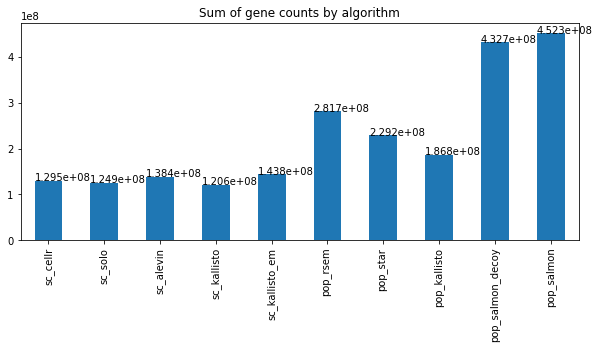

In [11]:
plot_sum_of_genes_by_algorithm()


# Genes detected by counts (All gene types)

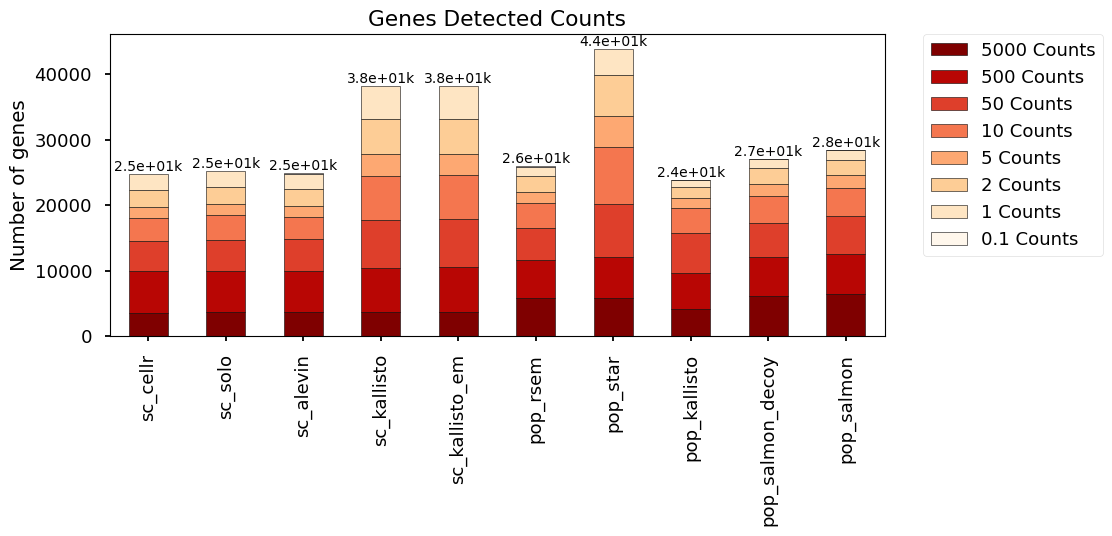

In [12]:
_ = plot_gene_detection_histogram(bin_library_quantification(gene_counts, "Counts"), "Genes Detected Counts", show_genes_detected=True, figsize=(10,4))

# Sum of Gene TPMs by Algorithm

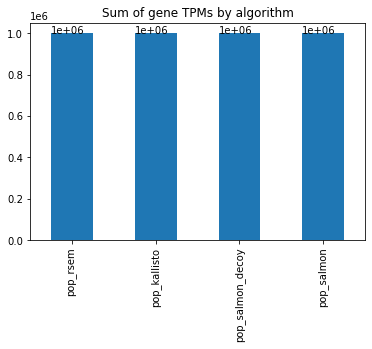

In [13]:
ax = gene_tpms.sum(axis=0).plot(kind='bar')
ax.set_title('Sum of gene TPMs by algorithm')
for p in ax.patches:
    ax.annotate('{:.3}'.format(p.get_height()), (p.get_x(), p.get_height()))


# Genes detected by TPM (All gene types)

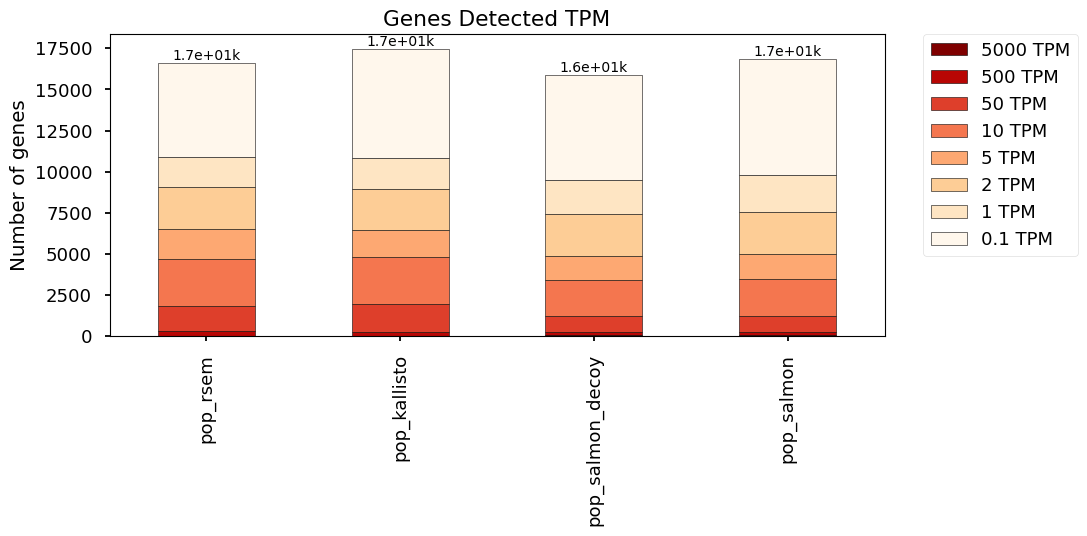

In [14]:
_ = plot_gene_detection_histogram(bin_library_quantification(gene_tpms, "TPM"), "Genes Detected TPM", show_genes_detected=True, figsize=(10,4))

# Sum of transcript counts by Algorithm

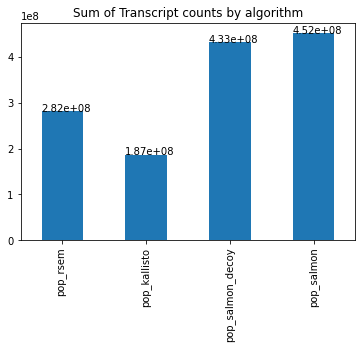

In [15]:
ax = transcript_counts.sum(axis=0).plot(kind='bar')
_ = ax.set_title('Sum of Transcript counts by algorithm')
for p in ax.patches:
    ax.annotate('{:.2e}'.format(int(p.get_height())), (p.get_x(), p.get_height()))



# Transcripts dected counts (All gene types)

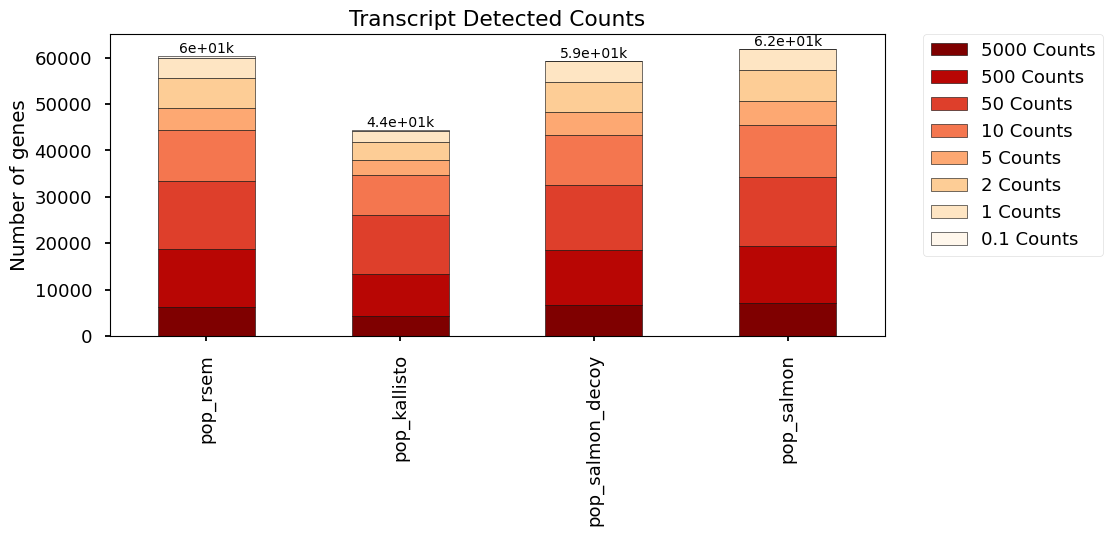

In [16]:
_ = plot_gene_detection_histogram(bin_library_quantification(transcript_counts, "Counts"), "Transcript Detected Counts", show_genes_detected=True, figsize=(10,4))

# Sum of transcript TPMs by Algorithm

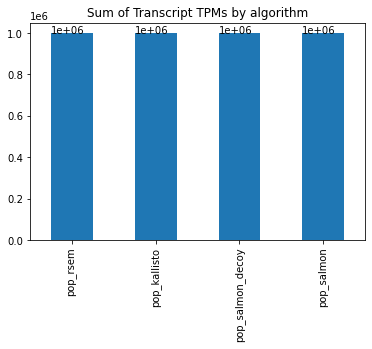

In [17]:
ax = transcript_tpms.sum(axis=0).plot(kind='bar')
_ = ax.set_title('Sum of Transcript TPMs by algorithm')
for i, p in enumerate(ax.patches):
    ax.annotate('{:.3}'.format(p.get_height()), (p.get_x(), p.get_height()))


# Transcripts dected using TPMs (All gene types)

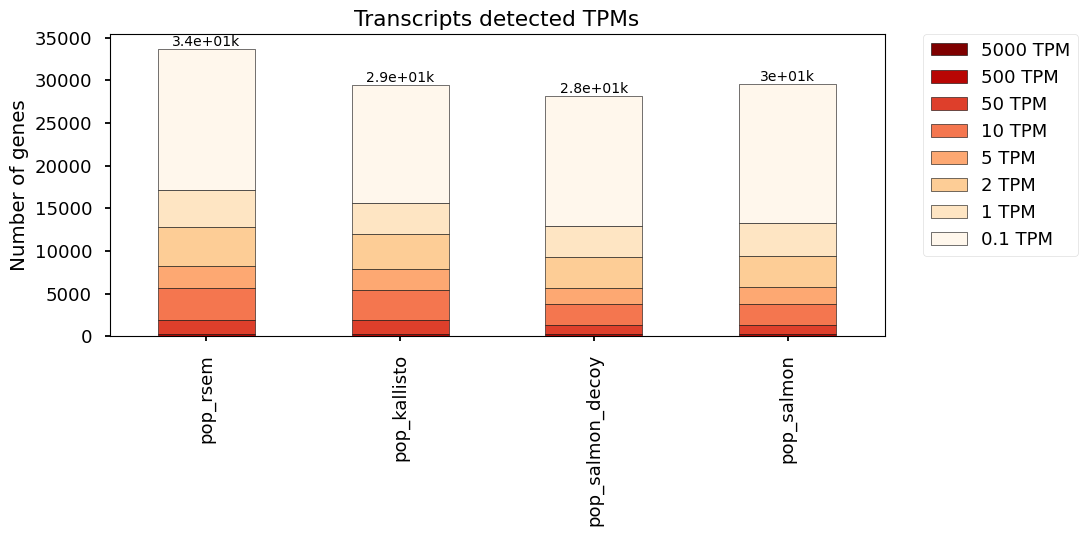

In [18]:
_ = plot_gene_detection_histogram(bin_library_quantification(transcript_tpms, "TPM"), "Transcripts detected TPMs", show_genes_detected=True, figsize=(10,4))

In [19]:
gene_count_scores = compute_all_vs_all_scores(gene_counts)
transcript_count_scores = compute_all_vs_all_scores(transcript_counts)
gene_tpm_scores = compute_all_vs_all_scores(gene_tpms)
transcript_tpm_scores = compute_all_vs_all_scores(transcript_tpms)

In [20]:
gene_color = ['tab:red' if x.startswith('gSpikein') else 'tab:blue' for x in gene_counts.index]
transcript_color = ['tab:red' if x.startswith('tSpikein') else 'tab:blue' for x in transcript_counts.index]

In [21]:
def plot_y_eq_x(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    bottom = (min(xmin, ymin), max(xmax, ymax))
    top = (min(xmin, ymin), max(xmax, ymax))
    ax.plot(bottom, top, color='k', linewidth=0.5)
    

In [22]:
def scatter_matrix(matrix, color, columns=None, rotation=0, figsize=None):
    if figsize is None:
        figsize = (6,6)
    f = pyplot.figure(figsize=figsize)
    
    if columns is None:
        columns = matrix.columns

    width = len(columns)
    axes = f.subplots(width, width, sharex=True, sharey=True)

    for x, x_name in enumerate(columns):
        for y, y_name in enumerate(columns):
            if x != y:
                axes[x,y].scatter(matrix[x_name], matrix[y_name], color=color, s=1.5)
            #gene_counts_log2.plot.scatter(x=x_name, y=y_name, color=color, ax=axes[x,y])
            if y == 0:
                axes[x, y].set_ylabel(x_name, rotation=rotation)
            if x == width-1:
                axes[x, y].set_xlabel(y_name, rotation=rotation)
          
    return f


# Show algorithms with similar performance

I want to show a scatter plot of all the algorithms, but there are enough of them it's hard to read, so I want to show some algorithms that can be removed because they perform similarly to each other

# Compare 10x Cellranger, STAR Solo, and Population STAR and RSEM

In [23]:
def plot_star():
    pairs = [
        ('sc_solo', 'sc_cellr'),
        ('sc_solo', 'pop_star'),
        ('sc_solo', 'pop_rsem'),

    ]
    f = pyplot.figure(figsize=(len(pairs)*3, 4))
    f.suptitle('log$_2$ STAR & Cellranger Gene Counts (Filtered Spearman)')
    axes = f.subplots(1,len(pairs),sharex=True,sharey=True)
    for i, (x, y) in enumerate(pairs):
        axes[i].scatter(gene_counts_log2[x], gene_counts_log2[y], color=gene_color, s=2)
        _ = axes[i].set_xlabel(x)
        _ = axes[i].set_ylabel(y)
        axes[i].text(0, 20, "({:0.3})".format(gene_count_scores['rafa_spearman'].loc[x,y]))
        plot_y_eq_x(axes[i])


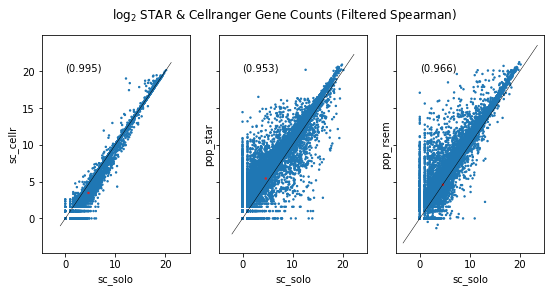

In [24]:
plot_star()

Single Cell STAR Solo matches Single Cell Cellranger quite well.

# Single Cell Kallisto gene counts

In [25]:
def plot_kallisto_gene_counts():
    pairs = [
        ('sc_kallisto', 'sc_kallisto_em'),
        ('sc_kallisto_em', 'pop_kallisto'),
        ('sc_kallisto', 'pop_kallisto'),
    ]
    f = pyplot.figure(figsize=(len(pairs)*3, 4))
    f.suptitle('Kallisto Gene Counts (Filtered Spearman)')
    axes = f.subplots(1,len(pairs),sharex=True,sharey=True)
    for i, (x, y) in enumerate(pairs):
        axes[i].scatter(gene_counts_log2[x], gene_counts_log2[y], color=gene_color, s=2)
        axes[i].text(-20, 25, "({:0.3})".format(gene_count_scores['rafa_spearman'].loc[x,y]))
        _ = axes[i].set_xlabel(x)
        _ = axes[i].set_ylabel(y)
        plot_y_eq_x(axes[i])


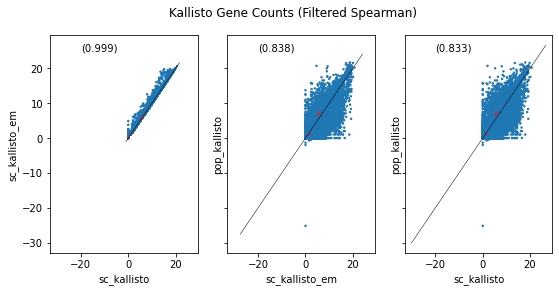

In [26]:
plot_kallisto_gene_counts()

The extra EM run with Kallisto doesn't seem to change much.

# Compare Salmon and Alevin Gene Counts

In [27]:
def plot_salmon_gene_counts():
    pairs = [
        ('sc_alevin', 'pop_salmon'),
        ('sc_alevin', 'pop_salmon_decoy'),
        ('pop_salmon', 'pop_salmon_decoy'),
    ]
    f = pyplot.figure(figsize=(len(pairs)*3, 4))
    f.suptitle('Salmon & Alevin Gene Counts (Filtered Spearman)')
    axes = f.subplots(1,len(pairs),sharex=True,sharey=True)
    for i, (x, y) in enumerate(pairs):
        axes[i].scatter(gene_counts_log2[x], gene_counts_log2[y], color=gene_color, s=2)
        axes[i].text(-10, 25, "({:0.3})".format(gene_count_scores['rafa_spearman'].loc[x,y]))
        _ = axes[i].set_xlabel(x)
        _ = axes[i].set_ylabel(y)
        plot_y_eq_x(axes[i])


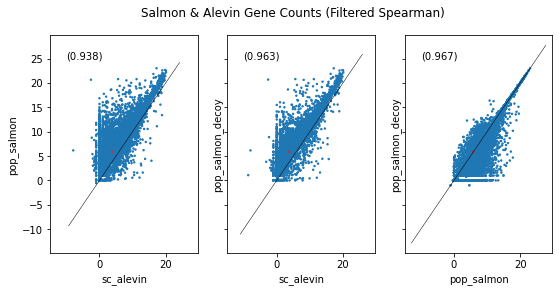

In [28]:
plot_salmon_gene_counts()

I didn't have a lot of space, so I'm still going to filter pop_salmon_decoy as it's still pretty similar to pop_salmon

# Compare Gene Counts

Remove the following categories from the big scatter plot because they have a mate they're fairly similar to.

In [29]:
#columns = ['sc_rsem', 'pop_rsem', 'pop_star', 'pop_kallisto', 'pop_salmon_decoy', 'pop_salmon'];
columns = ['sc_solo', 'sc_alevin', 'sc_kallisto', 'pop_rsem', 'pop_star', 'pop_kallisto', 'pop_salmon']
print('Removed: ', set(gene_counts_log2.columns).difference(columns))

Removed:  {'sc_cellr', 'pop_salmon_decoy', 'sc_kallisto_em'}


# Compare Gene Counts

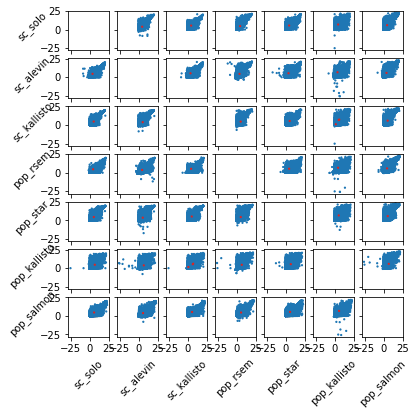

In [30]:
f = scatter_matrix(gene_counts_log2, gene_color, columns=columns, rotation=45)

# Heat map of gene count correlations

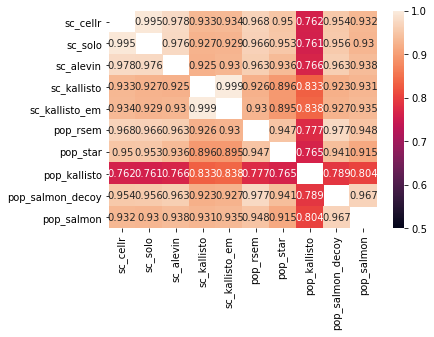

In [31]:
_ = seaborn.heatmap(gene_count_scores['rafa_spearman'], annot=True, fmt='.3g', vmin=vmin, vmax=1.0)

The population runs were treated as single ended, so maybe the estimates I used for the fragment sizes were wrong?

# Scatter matrix comparing Cellranger to population rsem and STAR gene counts

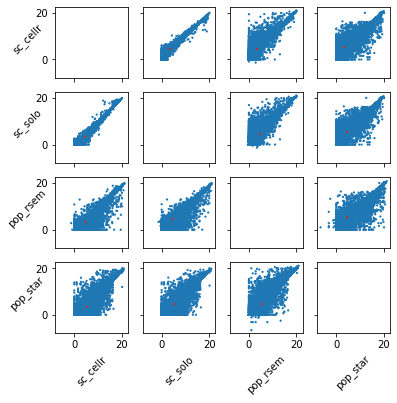

In [32]:
columns = ['sc_cellr', 'sc_solo', 'pop_rsem', 'pop_star']
f = scatter_matrix(gene_counts_log2,gene_color, columns=columns, rotation=45)

# Compare cellranger to alevin and population salmon gene counts

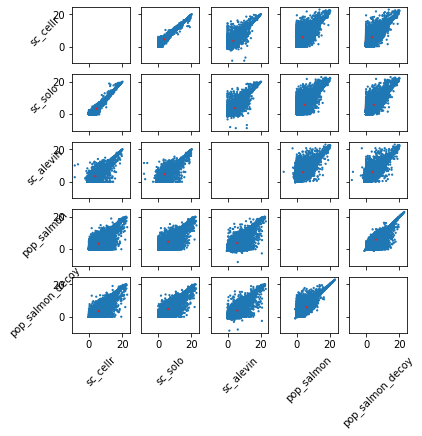

In [33]:
columns = ['sc_cellr', 'sc_solo', 'sc_alevin', 'pop_salmon', 'pop_salmon_decoy']
f = scatter_matrix(gene_counts_log2, gene_color, columns=columns, rotation=45)

# Compare Gene TPMs

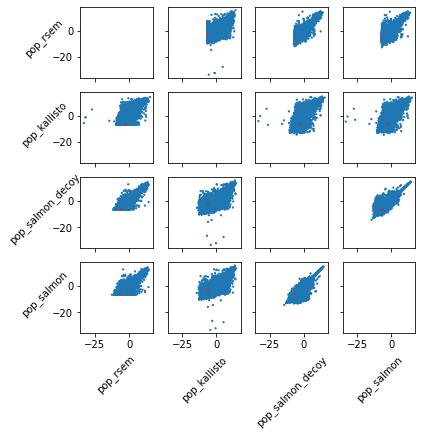

In [34]:
f = scatter_matrix(gene_tpms_log2, gene_color, rotation=45)

# Compare Gene TPM correlations

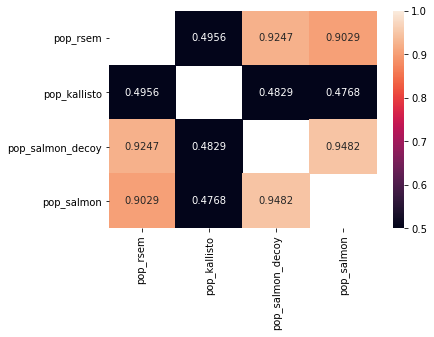

In [35]:
_ = seaborn.heatmap(gene_tpm_scores['rafa_spearman'], annot=True, fmt='.4g', vmin=vmin, vmax=1.0)

# Compare Transcript Counts

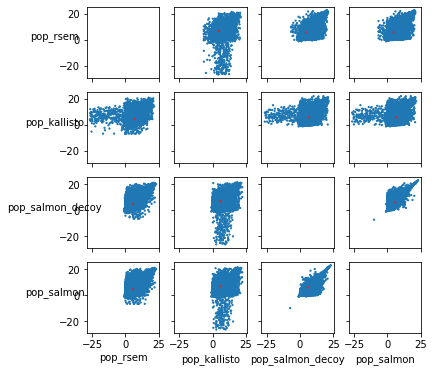

In [36]:
#columns = ['sc_rsem', 'pop_rsem', 'pop_kallisto', 'pop_salmon_decoy', 'pop_salmon']
f = scatter_matrix(transcript_counts_log2, transcript_color)

# Compare transcript count correlations

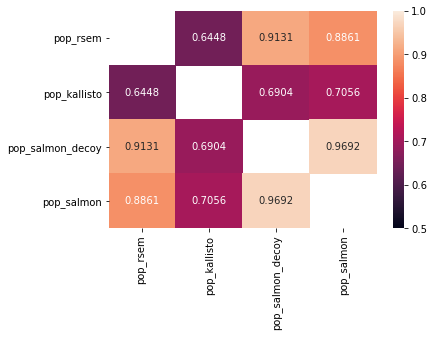

In [37]:
_ = seaborn.heatmap(transcript_count_scores['rafa_spearman'], annot=True, fmt='.4g', vmin=vmin, vmax=1.0)

# Compare Transcript TPMs

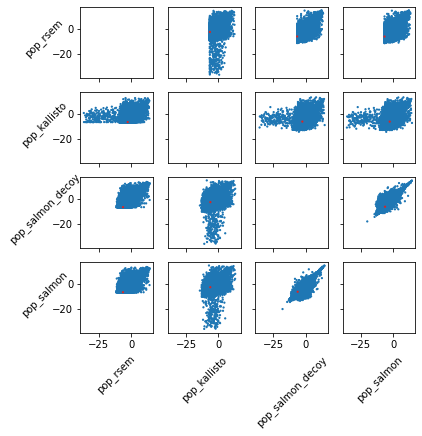

In [38]:
#columns=['sc_rsem', 'pop_rsem', 'pop_kallisto', 'pop_salmon_decoy', 'pop_salmon']
f = scatter_matrix(transcript_tpms_log2, transcript_color, rotation=45)


# Compare transcript TPM correlations

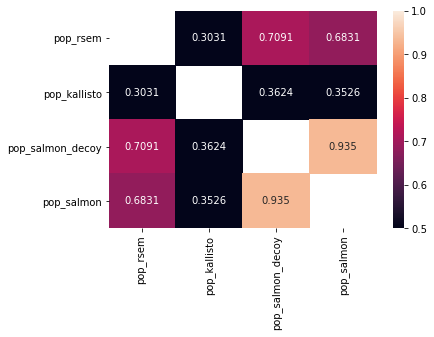

In [39]:
_ = seaborn.heatmap(transcript_tpm_scores['rafa_spearman'], annot=True, fmt='.4g', vmin=vmin, vmax=1.0)

# Highlight Kallisto

Zoom in on kallisto versus other algorithms.

In the following plots the one furthest to the right is RSEM vs Salmon (without decoy)

# Compare Kallisto Single Cell Counts

In [40]:
def plot_kallisto_sc_gene_counts():
    pairs = [
        ('sc_kallisto', 'sc_kallisto_em'),
        ('sc_kallisto_em', 'pop_kallisto'),
        ('sc_kallisto', 'pop_kallisto'),
        ('sc_kallisto', 'pop_rsem'),
        ('pop_kallisto', 'pop_rsem'),
    ]
    f = pyplot.figure(figsize=(len(pairs)*3, 4))
    f.suptitle('Kallisto Gene Counts (Filtered Spearman)')
    axes = f.subplots(1,len(pairs),sharex=True,sharey=True)
    for i, (x, y) in enumerate(pairs):
        axes[i].scatter(gene_counts_log2[x], gene_counts_log2[y], color=gene_color, s=2)
        axes[i].text(-20, 25, "({:0.3})".format(gene_count_scores['rafa_spearman'].loc[x,y]))
        _ = axes[i].set_xlabel(x)
        _ = axes[i].set_ylabel(y)
        plot_y_eq_x(axes[i])


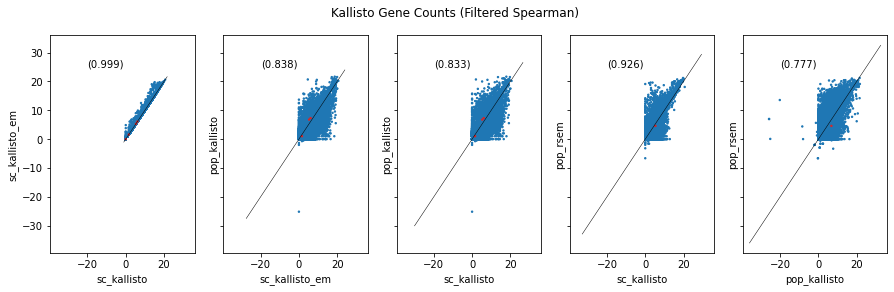

In [41]:
plot_kallisto_sc_gene_counts()

## Plot Kallisto Gene Counts

In [42]:
def plot_kallisto_pop_gene_counts():
    size = 3
    pairs = [        

        ('pop_kallisto', 'sc_cellr'),
        ('pop_kallisto', 'pop_star'),
        ('pop_kallisto', 'pop_rsem'),
        ('pop_kallisto', 'pop_salmon'),
        ('pop_rsem', 'pop_salmon'),        
    ]
    f = pyplot.figure(figsize=(14,6))
    f.suptitle('log$_2$ Gene Counts')
    axes = f.subplots(1,len(pairs), sharey=True, sharex=True)
    for i, (x, y) in enumerate(pairs):
        axes[i].scatter(gene_counts_log2[x], gene_counts_log2[y], color=gene_color, s=size)
        axes[i].text(-30, 30, "Spearman {:0.3}".format(gene_count_scores['rafa_spearman'].loc[x, y]))
        _ = axes[i].set_xlabel(x)
        _ = axes[i].set_ylabel(y)
        plot_y_eq_x(axes[i])

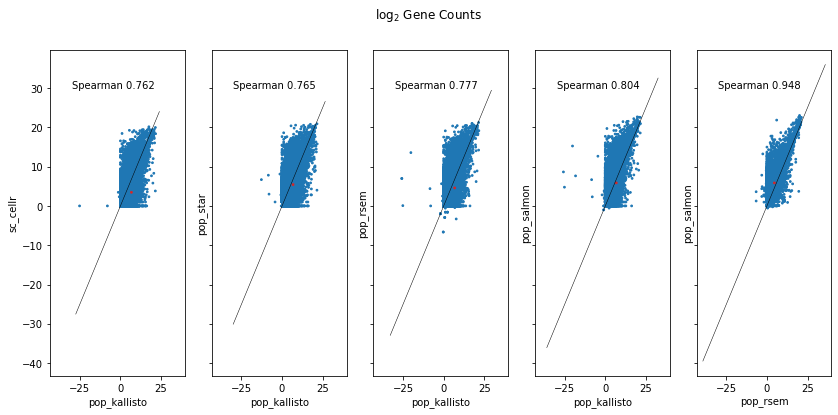

In [43]:
plot_kallisto_pop_gene_counts()

# What if we just floor kallisto gene counts?

In [44]:
def plot_kallisto_gene_counts_floored():
    size = 3
    f = pyplot.figure(figsize=(12,4))
    f.suptitle('log$_2$ Gene Counts clipped to -1.0 in log${_2}$ space')
    pairs = [
        ('pop_kallisto', 'sc_cellr'),
        ('pop_kallisto', 'pop_star'),
        ('pop_kallisto', 'pop_rsem'),
        ('pop_kallisto', 'pop_salmon'),
        ('pop_rsem', 'pop_salmon'),        
    ]
    axes = f.subplots(1, len(pairs), sharey=True, sharex=True)
    clipped = numpy.clip(gene_counts, .5, None)
    clipped_log2 = numpy.log2(clipped)
    for i, (x, y) in enumerate(pairs):
        scores = replicate_scores(clipped, x, y)
        #axes[i].set_title('Spearman = {:0.3}'.format(scores['rafa_spearman']))
        axes[i].text(0, 25, "Spearman {:0.3}".format(scores['rafa_spearman']))
        axes[i].scatter(clipped_log2[x], clipped_log2[y], color=gene_color, s=size)
        _ = axes[i].set_xlabel(x)
        _ = axes[i].set_ylabel(y)
        #print(scores)
        plot_y_eq_x(axes[i])

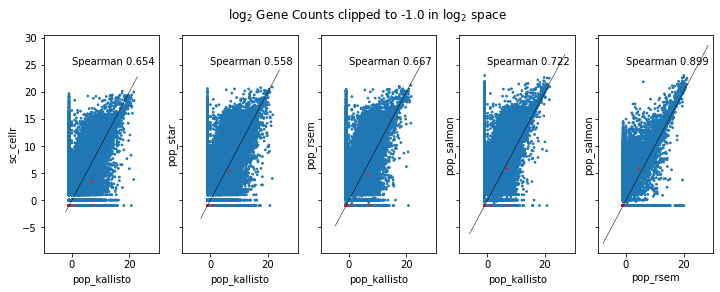

In [45]:
plot_kallisto_gene_counts_floored()

Well that didn't help.

## Kallisto Population Gene TPMs

In [46]:
def plot_kallisto_gene_tpm():
    size = 3
    f = pyplot.figure(figsize=(12,6))
    f.suptitle('log$_2$ Gene Counts')
    pairs = [
        ('pop_kallisto', 'pop_rsem'),
        ('pop_kallisto', 'pop_salmon'),
        ('pop_rsem', 'pop_salmon'),
    ]
    axes = f.subplots(1, len(pairs), sharey=True, sharex=True)
    for i, (x, y) in enumerate(pairs):
        axes[i].scatter(gene_tpms_log2[x], gene_tpms_log2[y], color=gene_color, s=size)
        _ = axes[i].set_xlabel(x)
        _ = axes[i].set_ylabel(y)
        plot_y_eq_x(axes[i])


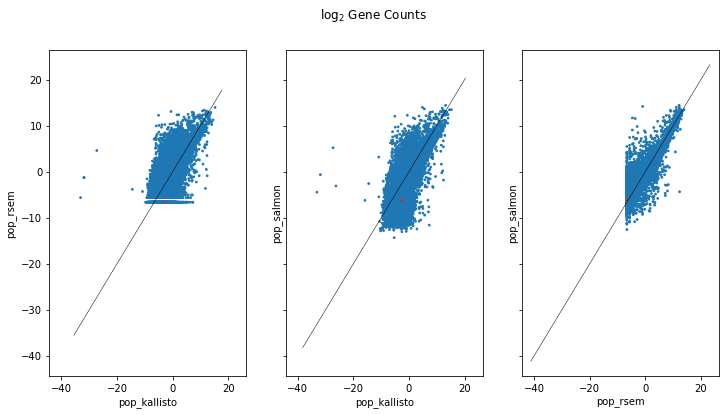

In [47]:
plot_kallisto_gene_tpm()

## Kallisto Population Transcript Counts

In [48]:
def plot_kallisto_transcript_counts():
    size = 3
    pairs = [     
        ('pop_kallisto', 'pop_rsem'),
        ('pop_kallisto', 'pop_salmon'),
        ('pop_kallisto', 'pop_salmon_decoy'),        
        ('pop_rsem', 'pop_salmon')
    ]
    f = pyplot.figure(figsize=(len(pairs)*3,4))
    f.suptitle('log$_2$ Transcript Counts')
    axes = f.subplots(1, len(pairs), sharex=True, sharey=True)
    for i, (x, y) in enumerate(pairs):
        axes[i].scatter(transcript_counts_log2[x], transcript_counts_log2[y], color=transcript_color, s=size)
        _ = axes[i].set_xlabel(x)
        _ = axes[i].set_ylabel(y)
        plot_y_eq_x(axes[i])


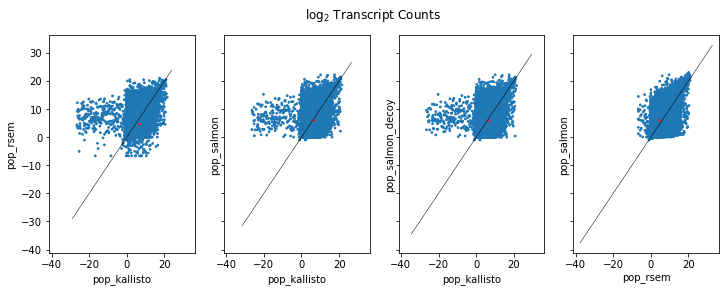

In [49]:
plot_kallisto_transcript_counts()

## Kallisto Population Transcript TPMs

In [50]:
def plot_kallisto_transcript_tpms():
    size = 3
    
    pairs = [
        ('pop_kallisto', 'pop_rsem'),
        ('pop_kallisto', 'pop_salmon'),
        ('pop_rsem', 'pop_salmon')
    ]
    f = pyplot.figure(figsize=(len(pairs)*3, 4))
    f.suptitle('log$_2$ Transcript TPMs')
    axes = f.subplots(1, len(pairs), sharex=True, sharey=True)
    for i, (x,y) in enumerate(pairs):
        axes[i].scatter(transcript_counts_log2[x], transcript_counts_log2[y], color=transcript_color, s=size)
        _ = axes[i].set_xlabel(x)
        _ = axes[i].set_ylabel(y)
        plot_y_eq_x(axes[i])


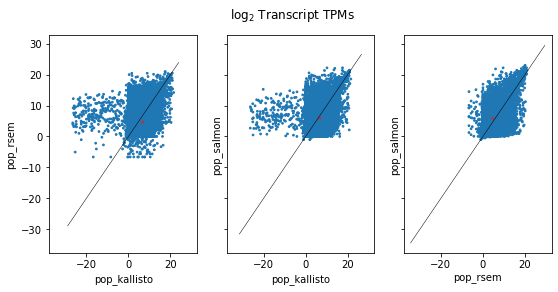

In [51]:
plot_kallisto_transcript_tpms()

# Conclusions

# Plot Graveyard

# Kallisto vs Rsem Gene TPMs

In [52]:
gene_tpms.columns

Index(['pop_rsem', 'pop_kallisto', 'pop_salmon_decoy', 'pop_salmon'], dtype='object')

In [53]:
def plot_kallisto_gene_tpms():
    pairs = [
        ('pop_kallisto', 'pop_rsem'),
        ('pop_kallisto', 'pop_salmon'),
        ('pop_kallisto', 'pop_salmon_decoy'),
    ]
    f = pyplot.figure(figsize=(len(pairs)*3, 4))
    f.suptitle('Population Gene TPMs (Filtered Spearman)')
    axes = f.subplots(1,len(pairs),sharex=True,sharey=True)
    for i, (x, y) in enumerate(pairs):
        axes[i].scatter(gene_tpms_log2[x], gene_tpms_log2[y], color=gene_color, s=2)
        axes[i].text(-30, 15, "({:0.3})".format(gene_tpm_scores['rafa_spearman'].loc[x,y]))
        _ = axes[i].set_xlabel(x)
        _ = axes[i].set_ylabel(y)
        plot_y_eq_x(axes[i])


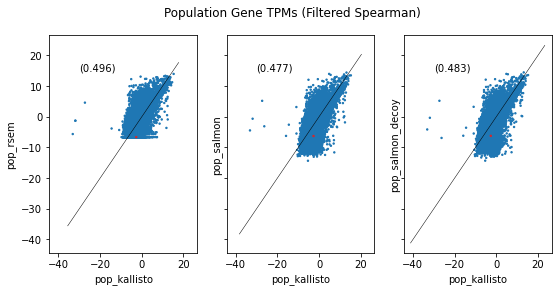

In [54]:
plot_kallisto_gene_tpms()

# Compare SmartSeq Salmon  gene counts and TPMs with and without decoy

In [55]:
def plot_salmon_genes():
    size = 3
    f = pyplot.figure(figsize=(10,4))
    ax = f.add_subplot(1,2,1)
    ax.scatter(gene_counts_log2['pop_salmon_decoy'], gene_counts_log2['pop_salmon'], color=gene_color, s=size)
    ax.text(0, 22, "({:0.3})".format(gene_count_scores['rafa_spearman'].loc['pop_salmon_decoy','pop_salmon']))
    _ = ax.set_ylabel('pop_salmon_decoy')
    _ = ax.set_xlabel('pop_salmon')
    plot_y_eq_x(ax)
    ax.set_title('log$_2$ Salmon Gene Counts')
    ax = f.add_subplot(1,2,2)
    _ = ax.scatter(gene_tpms_log2['pop_salmon_decoy'], gene_tpms_log2['pop_salmon'], color=gene_color, s=size)
    ax.text(-15, 14, "({:0.3})".format(gene_tpm_scores['rafa_spearman'].loc['pop_salmon_decoy','pop_salmon']))
    _ = ax.set_ylabel('pop_salmon_decoy')
    _ = ax.set_xlabel('pop_salmon')
    _ = ax.set_title('log$_2$ Salmon Gene TPMs')
    plot_y_eq_x(ax)


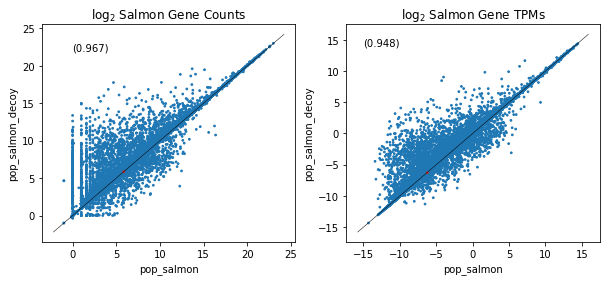

In [56]:
plot_salmon_genes()

# Compare SmartSeq Salmon transcript counts and TPMs with and without decoy

In [57]:
def plot_salmon_transcripts():
    size = 3
    f = pyplot.figure(figsize=(6, 4))
    axes = f.subplots(1, 2, sharex=True, sharey=True)
    
    axes[0].scatter(transcript_counts_log2['pop_salmon_decoy'], transcript_counts_log2['pop_salmon'], color=transcript_color, s=size)
    _ = axes[0].set_xlabel('pop_salmon_decoy')
    _ = axes[0].set_ylabel('sc_salmon')
    _ = axes[0].set_title('log$_2$ Transcript Counts')
    plot_y_eq_x(axes[0])
    axes[1].scatter(transcript_tpms_log2['pop_salmon_decoy'], transcript_tpms_log2['pop_salmon'], color=transcript_color, s=size)
    _ = axes[1].set_xlabel('pop_salmon_decoy')
    _ = axes[1].set_ylabel('sc_salmon')
    _ = axes[1].set_title('log$_2$ Transcript TPMs')
    plot_y_eq_x(axes[1])


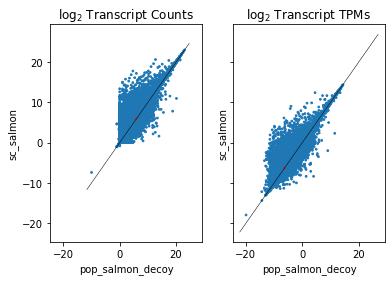

In [58]:
plot_salmon_transcripts()